# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Instructions

Setup matplotlib to work in Jupyter notebook.

There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.

You can find a list of the fields in the survey_fields variable in the notebook.

Consult the data dictionary that is part of the zip file that you can download here.

Are there any surprising correlations that you found?

Write up your results in a markdown cell.

# Plotting and analysing survey related correlations

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

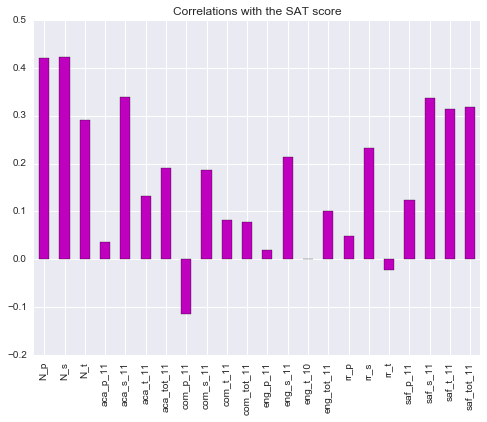

In [12]:
survey = survey_fields[:]
survey.remove("DBN")
corr_survey = correlations.loc[survey]
corr_survey.sort_index(inplace=True)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
corr_survey.plot(kind='bar',color='m')
plt.title("Correlations with the SAT score")
plt.show()

1) Most of the terms seem to show a positive correlation, except the comp_p_11, which is the communication score based on the parent's responses

2) The highest correlation is with the N_s and the N_p with N_t's correlation in between. Meaning, there is a higher correlation with the number of student and parent respondents than with the number of teacher respondents. This could mean that the schools where the parents and students' opinions are taken into account show a better SAT score. 

3) What is interesting is the difference in correlation between the actual number of responses and the response rates.
- N_s is higher than rr_s (both are positive)
- N_p is higher than rr_p (both are positive)
- N_t is higher than rr_t (rr_t is negative)

4) Safety statistics seem to have a high correlation as well (saf_p_11, saf_s_11, saf_t_11, saf_tot_11)

# Safety score analysis

Safety statistics seem to have a high correlation with the sat_scores. We can delve further into this. 

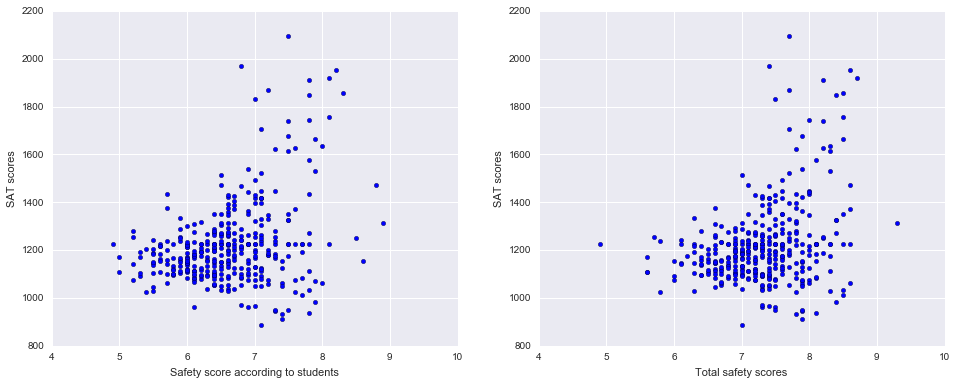

In [13]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(combined["saf_s_11"],combined["sat_score"])
ax1.set(xlabel="Safety score according to students",ylabel="SAT scores")

ax2.scatter(combined["saf_tot_11"],combined["sat_score"])
ax2.set(xlabel="Total safety scores",ylabel="SAT scores")

plt.show()

* There seems to be a tight cluster in the low safety score - low sat_score range with an ambiguous trend 
* As the score increases, the sat_scores seem to show a general upward trend, albiet in different rates (as can be concluded from the branching after the cluster)

In [14]:
for i in combined.columns:
    print(i)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [15]:
import numpy as np

In [16]:
# computing average safety scores for each district

safety = combined.groupby("school_dist").agg(np.mean)[["saf_tot_11","lat","lon"]]
safety

,saf_tot_11,lat,lon
school_dist,,,
01,7.433333,40.719022,-73.982377
02,7.520833,40.739699,-73.991386
03,7.233333,40.781574,-73.977370
04,7.714286,40.793449,-73.943215
05,7.085714,40.817077,-73.949251
06,7.660000,40.848970,-73.932502
07,7.392308,40.816815,-73.919971
08,7.218182,40.823803,-73.866087
09,7.365000,40.836349,-73.906240


In [17]:
from mpl_toolkits.basemap import Basemap

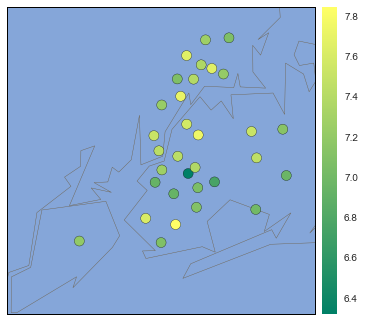

In [18]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#00FFFF', linewidth=.4)

longitudes = safety["lon"].tolist()
latitudes = safety["lat"].tolist()
m.scatter(longitudes, latitudes, s=100, zorder=2, latlon=True,c=safety["saf_tot_11"],cmap="summer")

m.colorbar()
plt.show()

![title](Images/boroughs.jpg)

When we compare the safety map with the above map of newyork boroughs, we can see that -

    1) Districts in manhattan seem to have a better safety score owing to a lighter dot on the map
    2) Districts in Brooklyn and Queens to have a few darker dots implying lower safety scores in the schools in that district